In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats
import early_warning_detection_functions
import matplotlib.pyplot as plt


In [2]:
df_aps = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_phc_with_otc_imed.parquet')

df_otc = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_otc_with_aps_imed.parquet')


df_aih = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_aih_imed2.parquet')


# Count warnings

In [3]:
df_aih.sum()

co_imed                                                                 17781180169
year_week                         2022-472022-482022-492022-502022-512022-522023...
warning_aih                                                                    2577
n                                                                           1803478
warning_aih_without_isolated                                                   1663
warning_aih_corect_with_consec                                                 1984
warning_final_aih                                                               556
dtype: object

In [5]:
df_aps.out_of_limits_below_aps_with_otc.sum()

10408

In [6]:
df_otc.out_of_limits_below_otc_with_aps.sum()

10335

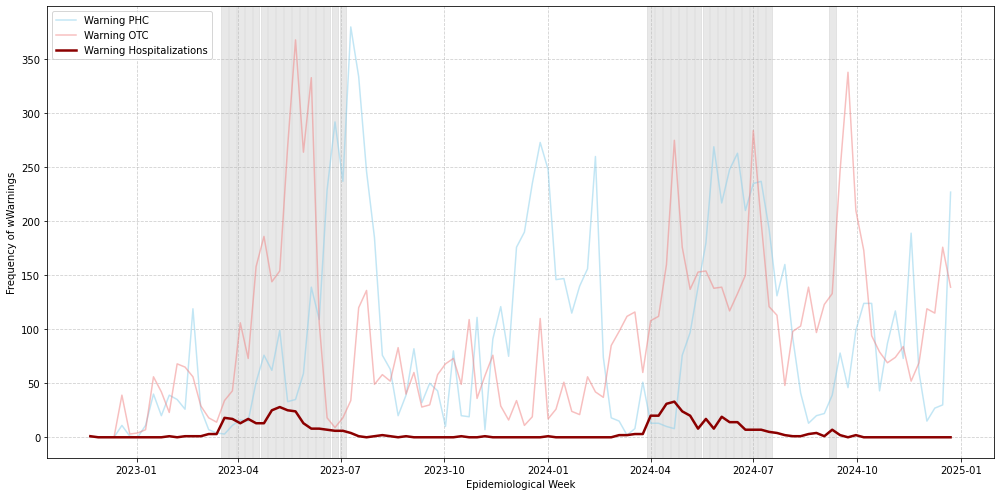

In [9]:
serie1 = df_aih.groupby(['year_week'])['warning_final_aih'].sum().reset_index()

serie2 = df_aps.groupby(['year_week', 'year_week_ts'])['out_of_limits_below_aps_with_otc'].sum().reset_index()

serie3 = df_otc.groupby(['year_week'])['out_of_limits_below_otc_with_aps'].sum().reset_index()

res1 = serie2.merge(serie1, on='year_week', how='left')

res2 = res1.merge(serie3, on='year_week', how='left')

# Define column for AIH warnings
col_aih = 'warning_final_aih'

# Assuming 'res2' already exists and 'year_week_ts' is the date column
dates = pd.to_datetime(res2['year_week_ts'])
res2 = res2.assign(year_week_ts = dates)
# Identify periods to highlight (replace with your logic to detect peaks)
# Example: Highlight weeks where warning_aih exceeds a threshold (adjust as needed)
highlight_weeks = res2[res2['warning_final_aih'] > res2['warning_final_aih'].quantile(0.7)]['year_week_ts']

# Plot setup
plt.figure(figsize=(14, 7))

# Plot with transparency for PHC and OTC
plt.plot(dates, res2['out_of_limits_below_aps_with_otc'], 
         label='Warning PHC', color='skyblue', alpha=0.5, linewidth=1.5)

plt.plot(dates, res2['out_of_limits_below_otc_with_aps'], 
         label='Warning OTC', color='lightcoral', alpha=0.5, linewidth=1.5)

# Bold line for AIH warnings
plt.plot(dates, res2['warning_final_aih'], 
         label='Warning Hospitalizations', color='darkred', linewidth=2.5)

# Add vertical highlight bands for peak weeks
for week in highlight_weeks:
    plt.axvspan(week - pd.Timedelta(days=3), week + pd.Timedelta(days=3), 
                color='lightgray', alpha=0.5)

# Format plot
plt.xlabel('Epidemiological Week')
plt.ylabel('Frequency of wWarnings')
#plt.title('Frequency of Warnings per Epidemiological Week')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.tight_layout()
plt.show()

In [10]:
res2[col_aih].quantile(0.7)

4.299999999999997

In [11]:
res2.warning_final_aih.describe()

count    110.000000
mean       5.054545
std        7.999812
min        0.000000
25%        0.000000
50%        1.000000
75%        7.000000
max       33.000000
Name: warning_final_aih, dtype: float64

In [12]:
dta_save = res2.rename(columns={'out_of_limits_below_aps_with_otc':'sinal_aps_bi',
                                'out_of_limits_below_otc_with_aps':'sinal_otc_bi',
                                 'warning_final_aih': 'sinal_aih'})

In [13]:
#dta_save[['year_week', 'year_week_ts', 'sinal_aps_bi', 'sinal_aih',
#       'sinal_otc_bi']].to_csv('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/dado_fig3_bi.csv')

In [14]:
test = res2.groupby(['year_week', 'year_week_ts'])[['out_of_limits_below_aps_with_otc','out_of_limits_below_otc_with_aps','warning_final_aih']].sum().reset_index()



In [15]:
test = test.assign(mes = test.year_week_ts.astype(str).str[5:7])

In [16]:
test.groupby(['mes'])[['out_of_limits_below_aps_with_otc','out_of_limits_below_otc_with_aps','warning_final_aih']].sum().reset_index()



,mes,out_of_limits_below_aps_with_otc,out_of_limits_below_otc_with_aps,warning_final_aih
0,01,906,271,2
1,02,714,438,3
2,03,101,495,51
3,04,278,1354,184
4,05,973,1781,168
5,06,1707,1005,83
6,07,2338,1122,37
7,08,364,670,13
8,09,491,1227,12
9,10,618,750,1


In [17]:
#test[30:50]

# Counting antecipations

In [20]:
def antici_count(data_res, col_warn_s1, col_warn_s2, col_code):
    """
    Function to compute anticipated counts of warnings and missed warnings 
    across different lead times per unique region.
    
    Parameters:
    data_res (pd.DataFrame): Input DataFrame.
    col_warn_s1 (str): Column name for the primary warning signal (e.g., PHC warnings).
    col_warn_s2 (str): Column name for the secondary warning signal (e.g., AIH warnings).
    col_code (str): Column name identifying the region.

    Returns:
    pd.DataFrame: Summary DataFrame with counts of early, concurrent, and missed warnings.
    """
    
    lst_count = []

    for code in data_res[col_code].unique():
    
        dta = data_res[data_res[col_code] == code].copy()  # Use only data for the current region

        # Find sets based on PHC warnings (col_warn_s1) and AIH warnings (col_warn_s2) at different lags
        set3 = dta[(dta[col_warn_s1] == 1) & (dta[col_warn_s2].shift(-3) == 1)].index + 3
        set2 = dta[(dta[col_warn_s1] == 1) & (dta[col_warn_s2].shift(-3) == 0) & (dta[col_warn_s2].shift(-2) == 1)].index + 2
        set1 = dta[(dta[col_warn_s1] == 1) & 
                   (dta[col_warn_s2].shift(-3) == 0) & 
                   (dta[col_warn_s2].shift(-2) == 0) & 
                   (dta[col_warn_s2].shift(-1) == 1)].index + 1
        set0 = dta[(dta[col_warn_s1] == 1) & 
                   (dta[col_warn_s2] == 1) & 
                   (dta[col_warn_s2].shift(-3) == 0) & 
                   (dta[col_warn_s2].shift(-2) == 0) & 
                   (dta[col_warn_s2].shift(-1) == 0)].index
        
        # Identify True Negatives (TN)
        set_tn1 = dta[(dta[col_warn_s2] == 0) &  # AIH warning is 0
                      (dta[col_warn_s1] == 0) & 
                      (dta[col_warn_s1].shift(1).fillna(0) == 0) & 
                      (dta[col_warn_s1].shift(2).fillna(0) == 0) & 
                      (dta[col_warn_s1].shift(3).fillna(0) == 0)
                    ].index
        
        set_fp1 = dta[(dta[col_warn_s2] == 0) & 
                   ((dta[col_warn_s1] == 1) | 
                   (dta[col_warn_s1].shift(3).fillna(0) == 1) | 
                   (dta[col_warn_s1].shift(2).fillna(0) == 1) | 
                   (dta[col_warn_s1].shift(1).fillna(0) == 1))].index

        # Warnings in PHC right after an AIH warning (possibly not anticipated but concurrent)
        set1_after = dta[(dta[col_warn_s1].shift(-1) == 1) & (dta[col_warn_s2] == 1)].index
        
       

        # Compute counts of warnings at different lead times
        n3 = len(set3)
        n2 = len(set(set2) - set(set3))
        n1 = len((set(set1) - set(set3)) - set(set2))
        n0 = len(((set(set0) - set(set3)) - set(set2)) - set(set1))
        n1_after = len((((set(set1_after) - set(set3)) - set(set2)) - set(set1)) - set(set0))
        n_tn1 = len(set_tn1) 
        n_fp1 = len(set_fp1)

        # Drop all anticipated and concurrent warnings to count missed ones
        ind_drop = set(set3) | set(set2) | set(set1) | set(set0) #| set(set1_after)
        missed = dta.drop(index=ind_drop)[col_warn_s2].sum()
        
        TP = n3 + n2 + n1 + n0
        
        # outra forma de calcular o FN
        #set_FN = dta[(dta[col_warn_s2] == 1) &  
        #           (dta[col_warn_s1] == 0) & 
        #           (dta[col_warn_s1].shift(3).fillna(0) == 0) & 
        #           (dta[col_warn_s1].shift(2).fillna(0) == 0) & 
        #           (dta[col_warn_s1].shift(1).fillna(0) == 0)].index
        
        
        # Create the results dictionary for this region
        data = {
            col_code: [code],
            'n3': [n3],
            'n2': [n2],
            'n1': [n1],
            'n0': [n0],
            'n1_after': [n1_after],
            'missed': [missed],
            'TP': [TP],
            'TN1': [n_tn1], # True Negative
            'FP1': [n_fp1], # False Positive
            'FN': missed,
            'total_aih_warning': [dta[col_warn_s2].sum()]
        }

        # Append to results list
        data_output = pd.DataFrame(data)
        lst_count.append(data_output)

    # Combine all results into a single DataFrame
    df_warning_count = pd.concat(lst_count, ignore_index=True)
    
    return df_warning_count


In [21]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_below_aps_with_otc']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_below_otc_with_aps']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_final_aih']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

### APS e AIH

In [22]:
df_warning_count = antici_count(result, 'out_of_limits_below_aps_with_otc', 'warning_final_aih', 'co_imed')

In [23]:
def summarize_performance(df_warning_count):
    """
    Summarizes performance metrics including Sensitivity, Specificity, PPV, F1-score, POD, and FPR.
    
    Parameters:
    df_warning_count (pd.DataFrame): Dataframe containing warning counts and classification metrics.
    
    Returns:
    pd.DataFrame: Summary table with performance metrics.
    """
    # Total AIH Warnings
    total_warnings = df_warning_count.total_aih_warning.sum()
    
    # Early Detection (1 to 3 weeks)
    early_count = df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum()
    early_rate = round((early_count * 100) / total_warnings, 1)
    
    # Timely Detection (0 week)
    timely_count = df_warning_count.n0.sum()
    timely_rate = round((timely_count * 100) / total_warnings, 1)
    
    # Missed Warnings
    missed_count = df_warning_count.missed.sum()
    missed_rate = round((missed_count * 100) / total_warnings, 1)
    
    # Classification Metrics
    TP = df_warning_count.TP.sum()
    FN = df_warning_count.FN.sum()
    TN = df_warning_count.TN1.sum()
    FP = df_warning_count.FP1.sum()

    
    # Sensitivity (Recall)
    Sensitivity = round((TP / (TP + FN)) * 100, 1) if (TP + FN) > 0 else 0
    
    # Specificity
    Specificity = round((TN / (TN + FP)) * 100, 1) if (TN + FP) > 0 else 0
    
    # Positive Predictive Value (PPV)
    PPV = round((TP / (TP + FP)) * 100, 1) if (TP + FP) > 0 else 0
    
    # F1-score
    F1_score = round(2 * (TP / (TP + FN)) * (TP / (TP + FP)) / ((TP / (TP + FN)) + (TP / (TP + FP))), 2) if ((TP / (TP + FN)) + (TP / (TP + FP))) > 0 else 0
    
    Precision = round(((TP + TN) / (TP + TN + FP + FN) * 100), 1) if (TP + TN + FP + FN) > 0 else 0

    # Probability of Detection (POD)
    POD = round(((early_count + timely_count + df_warning_count.n1_after.sum()) / total_warnings) * 100, 1)
    
    # False Positive Rate (FPR)
    FPR = round((FP / (FP + TN)) * 100, 1) if (FP + TN) > 0 else 0
    
    # Create summary DataFrame
    summary_df = pd.DataFrame({
        "Metric": ["Total Warnings", "Early Detection (1-3 weeks)", "Timely Detection (0 weeks)", "Missed Warnings",
                   "Sensitivity ", "Specificity", "PPV",  "POD", "FPR","Precision (%)"],
        "Value": [total_warnings, f"{early_count} ({early_rate}%)", f"{timely_count} ({timely_rate}%)", f"{missed_count} ({missed_rate}%)",
                   f"{Sensitivity}%", f"{Specificity}%", f"{PPV}%", f"{POD}%", f"{FPR}%", f"{Precision}%"]
    })
    
    return summary_df



In [24]:
performance_summary = summarize_performance(df_warning_count)


In [25]:
performance_summary

,Metric,Value
0,Total Warnings,556
1,Early Detection (1-3 weeks),122 (21.9%)
2,Timely Detection (0 weeks),36 (6.5%)
3,Missed Warnings,398 (71.6%)
4,Sensitivity,28.4%
5,Specificity,62.4%
6,PPV,0.8%
7,POD,36.2%
8,FPR,37.6%
9,Precision (%),62.0%


### OTC and AIH

In [35]:
df_warning_count = antici_count(result, 'out_of_limits_below_otc_with_aps', 'warning_final_aih', 'co_imed')


In [36]:
performance_summary = summarize_performance(df_warning_count)


In [37]:
performance_summary

,Metric,Value
0,Total Warnings,556
1,Early Detection (1-3 weeks),253 (45.5%)
2,Timely Detection (0 weeks),72 (12.9%)
3,Missed Warnings,231 (41.5%)
4,Sensitivity,58.5%
5,Specificity,59.8%
6,PPV,1.4%
7,POD,70.0%
8,FPR,40.2%
9,Precision (%),59.8%


## OTC and APS

In [38]:
df_warning_count = antici_count(result, 'out_of_limits_below_otc_with_aps', 'out_of_limits_below_aps_with_otc', 'co_imed')


In [39]:
performance_summary = summarize_performance(df_warning_count)


In [40]:
performance_summary

,Metric,Value
0,Total Warnings,10339
1,Early Detection (1-3 weeks),2992 (28.9%)
2,Timely Detection (0 weeks),177 (1.7%)
3,Missed Warnings,7170 (69.3%)
4,Sensitivity,30.7%
5,Specificity,60.6%
6,PPV,15.0%
7,POD,45.7%
8,FPR,39.4%
9,Precision (%),55.0%


# APS and OTC

In [41]:
df_warning_count = antici_count(result, 'out_of_limits_below_aps_with_otc', 'out_of_limits_below_otc_with_aps', 'co_imed')

In [42]:
performance_summary = summarize_performance(df_warning_count)


In [43]:
performance_summary

,Metric,Value
0,Total Warnings,10279
1,Early Detection (1-3 weeks),2813 (27.4%)
2,Timely Detection (0 weeks),131 (1.3%)
3,Missed Warnings,7335 (71.4%)
4,Sensitivity,28.6%
5,Specificity,63.3%
6,PPV,15.0%
7,POD,42.4%
8,FPR,36.7%
9,Precision (%),56.9%


# Study peformance by macro region and pop size

In [44]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_below_aps_with_otc']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_below_otc_with_aps']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_final_aih']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

In [197]:
# Read dictionary with municipalities
df_imed_key = pd.read_csv('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/RELATORIO_DTB_BRASIL_MUNICIPIO.csv',sep = ';')
df_pop = pd.read_csv('/Users/julianeoliveira/Documents/Projects/AESOP/AESOP datalake/Population/table_2009_2023_etcc_eq_zero.csv')


In [198]:
df_pop = df_pop[['Cód.', 'Uf', '2022']]

df_imed_key = df_imed_key[['Nome_UF', 'UF',  'Região Geográfica Imediata',
       'Nome Região Geográfica Imediata', 
       'Município', 'Código Município Completo', 'Nome_Município']]

df_pop = df_pop.rename(columns = {'Cód.': 'co_ibge7'}) 

df_imed_key = df_imed_key.rename(columns = {'Código Município Completo': 'co_ibge7', 
                                            'Região Geográfica Imediata': 'co_imed'})

df_imed_key = df_imed_key.merge(df_pop, on='co_ibge7', how='left')

df_imed_pop = df_imed_key.groupby(['co_imed'])['2022'].sum().reset_index()

df_imed_pop = df_imed_pop.assign(pop_2022 = df_imed_pop['2022'].astype(int))
df_imed_pop = df_imed_pop[['co_imed', 'pop_2022']]


df_codes_imed = df_imed_key.groupby(['Nome_UF','UF', 'co_imed','Uf'])['2022'].sum().reset_index()



In [199]:
# Dictionary mapping Brazilian states to their regions
state_to_region = {
    "AC": "North", "AM": "North", "AP": "North", "PA": "North", "RO": "North", "RR": "North", "TO": "North",
    "AL": "Northeast", "BA": "Northeast", "CE": "Northeast", "MA": "Northeast", "PB": "Northeast",
    "PE": "Northeast", "PI": "Northeast", "RN": "Northeast", "SE": "Northeast",
    "DF": "Center-West", "GO": "Center-West", "MT": "Center-West", "MS": "Center-West",
    "ES": "Southeast", "MG": "Southeast", "RJ": "Southeast", "SP": "Southeast",
    "PR": "South", "RS": "South", "SC": "South"
}


result2 = result.merge(df_codes_imed, on='co_imed', how='left')

# Create a new column 'region' by mapping state codes to regions
result2["region"] = result2["Uf"].map(state_to_region)
